In [34]:
import sys
import math
sys.path.append("/Users/rafalpwiewiora/repos/NMpathAnalysis/nmpath")
import matplotlib
import matplotlib as mpl
matplotlib.rcParams['figure.facecolor'] = '1'
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display
import multiprocessing

In [35]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list, tAB_interval=None):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    if tAB_interval is not None:
        ax1.set_ylim(tAB_interval[0],tAB_interval[1])
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()

def rmsd_of_cluster(cluster, rmsd, dtraj):
    rmsd_list=[]
    for i,element in enumerate(rmsd):
        if dtraj[i] in cluster:
            rmsd_list.append(element)
    length = len(rmsd_list)
    
    if length == 0:
        return None

    return sum(rmsd_list)/length



color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']
color_sequence+=color_sequence


def cdf(pmf):
    mycdf=[]
    tot = 0
    for element in pmf:
        tot+= element
        mycdf.append(tot)
    return np.array(mycdf)



def confindence_interval_cdf(populations, totCounts, conf_interval=0.95, n_samples=100000):
    counts = np.round(np.array(populations)*totCounts)
    partialCounts = sum(counts)
    myarray = list(counts)+[totCounts-partialCounts]
    s=np.random.dirichlet(myarray,n_samples)

    s_cdf = []

    for line in s:
        s_cdf.append(cdf(line))
    s_cdf = np.array(s_cdf)

    s = np.transpose(s)
    s_cdf = np.transpose(s_cdf)

    minval = []
    maxval = []
    minvalcdf = []
    maxvalcdf = []

    for line in s:
        sorted_line = np.sort(line)
        minval.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxval.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])

    for line in s_cdf:
        sorted_line = np.sort(line)
        minvalcdf.append(sorted_line[int(     (1-conf_interval)/2  * len(sorted_line))])
        maxvalcdf.append(sorted_line[int(  (1-(1-conf_interval)/2) * len(sorted_line))])
    
    return minvalcdf[:-1], maxvalcdf[:-1]

In [42]:
dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/chignolin/chignolin_dtrajs_lag10ns.npy")

In [13]:
msm1 = pyemma.msm.estimate_markov_model(list(dtrajs), lag=1, dt_traj='0.0002 us')

In [56]:
range_per_lag = [[200,7000]]

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 67.20ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 94.40ns, t_min: 102.81ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 121.60ns, t_min: 125.66ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 148.80ns, t_min: 150.10ns, t_max: 1.24e+03ns, tAB: 355.56ns
t_cut: 176.00ns, t_min: 176.20ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 203.20ns, t_min: 204.89ns, t_max: 1.24e+03ns, tAB: 345.31ns
t_cut: 230.40ns, t_min: 230.92ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 257.60ns, t_min: 261.95ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 284.80ns, t_min: 291.48ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 312.00ns, t_min: 313.20ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 339.20ns, t_min: 352.45ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 366.40ns, t_min: 378.09ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 393.60ns, t_min: 397.54ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 420.80ns, t_min: 427.62ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cu

#### t_AB plots:

<Figure size 1296x5875.2 with 0 Axes>

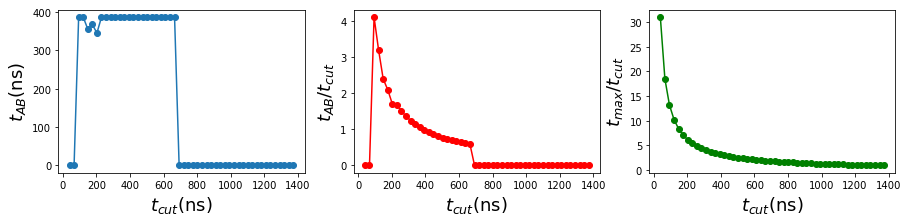

In [6]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//50
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

In [14]:
range_per_lag = [[200,3500]]

### Lag-time: 0.2ns

#### t_values:

t_cut: 40.00ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 53.20ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 66.40ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 79.60ns, t_min: 86.84ns, t_max: 1.24e+03ns, tAB: 0.00ns
t_cut: 92.80ns, t_min: 102.81ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 106.00ns, t_min: 109.35ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 119.20ns, t_min: 119.25ns, t_max: 1.24e+03ns, tAB: 386.78ns
t_cut: 132.40ns, t_min: 133.73ns, t_max: 1.24e+03ns, tAB: 355.56ns
t_cut: 145.60ns, t_min: 150.10ns, t_max: 1.24e+03ns, tAB: 355.56ns
t_cut: 158.80ns, t_min: 166.24ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 172.00ns, t_min: 173.57ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 185.20ns, t_min: 191.49ns, t_max: 1.24e+03ns, tAB: 345.31ns
t_cut: 198.40ns, t_min: 204.89ns, t_max: 1.24e+03ns, tAB: 345.31ns
t_cut: 211.60ns, t_min: 212.30ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 224.80ns, t_min: 226.78ns, t_max: 1.24e+03ns, tAB: 367.59ns
t_cut: 238.0

#### t_AB plots:

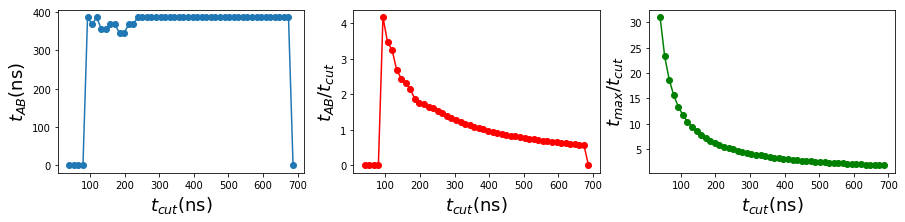

In [15]:
K = msm1.P
dt = 0.2
#---------------------
printmd("### Lag-time: "+str(dt)+"ns")

t_min_list=[]
t_max_list=[]
t_AB_list=[]

big_clusters_list = []

# t_cut range
min_ = range_per_lag[0][0]
max_ = range_per_lag[0][1]
interval = (max_ - min_)//50
t_cut_values =  [min_+i for i in range(0,max_- min_,interval)]


fig_n_cols = 3
fig_n_rows = int(math.ceil(len(t_cut_values)/fig_n_cols))


fig = plt.figure(figsize=(6*fig_n_cols, 4.8*fig_n_rows))

printmd("#### t_values:")

for ii, t_cut in enumerate(t_cut_values):

    big_clusters=[]
    big_clusters_index =[]

    # clustering
    
    clusters, t_min, t_max = kinetic_clustering2_from_tmatrix(K, t_cut=t_cut, verbose=False)


    t_min_list.append(t_min)
    t_max_list.append(t_max)

    for i, cluster_i in enumerate(clusters):
        if len(cluster_i) > 1:
            big_clusters.append(cluster_i)
            big_clusters_index.append(i)

    n_big = len(big_clusters)

    macrostates = biggest_clusters_indexes(big_clusters, n_pick=2)
    big_clusters_list.append(big_clusters)

    if n_big > 1:
        tAB = markov_commute_time(K,[macrostates[0]],[macrostates[1]] )
    else:
        tAB = 0.0
    t_AB_list.append(tAB)

    print("t_cut: {:.2f}ns, t_min: {:.2f}ns, t_max: {:.2e}ns, tAB: {:.2f}ns".format(t_cut*dt, t_min*dt, t_max*dt, tAB*dt))

printmd("#### t_AB plots:")
plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list)

In [59]:
(np.array(t_AB_list)*0.2)[15:49]

array([386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404, 386.77684404, 386.77684404,
       386.77684404, 386.77684404])

In [63]:
interm_lengths = []

for i in range(15,49):

    pick = i

    #Selection of the t_cut
    macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
    # Folded and unfolded definition
    stateA = big_clusters_list[pick][macrostates[0]]
    stateB = big_clusters_list[pick][macrostates[1]]
    
    interm_lengths.append(100 - (len(stateA)+len(stateB)))

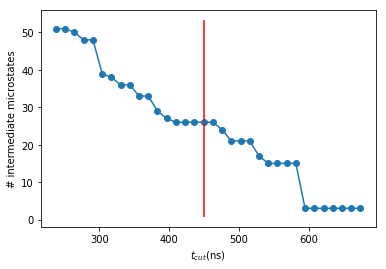

In [113]:
plt.figure()
plt.scatter(np.array(t_cut_values)[15:49]*0.2, interm_lengths)
plt.plot(np.array(t_cut_values)[15:49]*0.2, interm_lengths)
plt.xlabel("$t_{cut}\mathrm{(ns)}$")
plt.ylabel('# intermediate microstates')
plt.vlines((np.array(t_cut_values)*0.2)[31], plt.ylim()[0], plt.ylim()[1], color='r')
plt.show()

In [60]:
(np.array(t_cut_values)*0.2)[31] # choose in the middle of the plateau

449.20000000000005

In [254]:
pick = 31

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [255]:
print(stateA)

[1, 45, 3, 68, 69, 10, 29, 80, 7, 58, 11, 86, 38, 66, 25, 30, 90, 17, 46, 89, 49, 76, 36, 50, 92, 77, 26, 27, 2, 56, 20, 54, 9, 67, 93, 83, 95, 34, 48, 99, 47, 62, 94, 81, 18, 57, 79]


In [256]:
len(stateA)

47

In [257]:
print(stateB)

[0, 23, 52, 85, 44, 21, 41, 35, 71, 24, 8, 55, 64, 78, 31, 84, 43, 72, 12, 65, 39, 70, 88, 42, 14, 5, 40]


In [258]:
len(stateB)

27

In [259]:
100 - (len(stateA) + len(stateB))

26

In [261]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

In [16]:
def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

In [264]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 624/624
Number of A->B/B->A  events: 280/280
Number of A->B/B->A  events: 198/198
Number of A->B/B->A  events: 140/140
Number of A->B/B->A  events: 89/89
Number of A->B/B->A  events: 45/44
Number of A->B/B->A  events: 38/37
Number of A->B/B->A  events: 32/31
Number of A->B/B->A  events: 15/14
Number of A->B/B->A  events: 10/9
Number of A->B/B->A  events: 3/2
Number of A->B/B->A  events: 3/2


In [265]:
np.save('chignolin_empirical_mfptsAB_agglomerative_cluster', empirical_mfptsAB)
np.save('chignolin_empirical_mfptsBA_agglomerative_cluster', empirical_mfptsBA)
np.save('chignolin_std_errAB_agglomerative_cluster', std_errAB)
np.save('chignolin_std_errBA_agglomerative_cluster', std_errBA)
np.save('chignolin_nm_mfptsAB_agglomerative_cluster', nm_mfptsAB)
np.save('chignolin_nm_mfptsBA_agglomerative_cluster', nm_mfptsBA)
np.save('chignolin_nm_hist10ns_mfptsAB_agglomerative_cluster', nm_hist10ns_mfptsAB)
np.save('chignolin_nm_hist10ns_mfptsBA_agglomerative_cluster', nm_hist10ns_mfptsBA)
np.save('chignolin_nm_hist100ns_mfptsAB_agglomerative_cluster', nm_hist100ns_mfptsAB)
np.save('chignolin_nm_hist100ns_mfptsBA_agglomerative_cluster', nm_hist100ns_mfptsBA)

In [99]:
empirical_mfptsAB2 = np.load('chignolin_empirical_mfptsAB.npy')
empirical_mfptsBA2 = np.load('chignolin_empirical_mfptsBA.npy')
std_errAB2 = np.load('chignolin_std_errAB.npy')
std_errBA2 = np.load('chignolin_std_errBA.npy')
nm_mfptsAB2 = np.load('chignolin_nm_mfptsAB.npy')
nm_mfptsBA2 = np.load('chignolin_nm_mfptsBA.npy')
nm_hist10ns_mfptsAB2 = np.load('chignolin_nm_hist10ns_mfptsAB.npy')
nm_hist10ns_mfptsBA2 = np.load('chignolin_nm_hist10ns_mfptsBA.npy')
nm_hist100ns_mfptsAB2 = np.load('chignolin_nm_hist100ns_mfptsAB.npy')
nm_hist100ns_mfptsBA2 = np.load('chignolin_nm_hist100ns_mfptsBA.npy')

dtrajs = np.load("../vamp_scoring/automatic_eigenvalue/chignolin/chignolin_dtrajs_lag10ns.npy")

#unfolded
stateA = [1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 15, 16, 17, 18, 20, 22, 25, 26, 27, 28, 29, 30, 32, 33, 34, 36, 37, 38, 45, 46, 47, 48, 49, 50, 53, 54, 56, 57, 58, 59, 61, 62, 63, 66, 67, 68, 69, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 86, 87, 89, 90, 91, 92, 93, 94, 95, 98, 99]

#folded
stateB = [0, 8, 12, 21, 23, 24, 31, 35, 39, 41, 43, 44, 52, 55, 64, 65, 70, 71, 72, 78, 84, 85]

lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB2 = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA2 = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

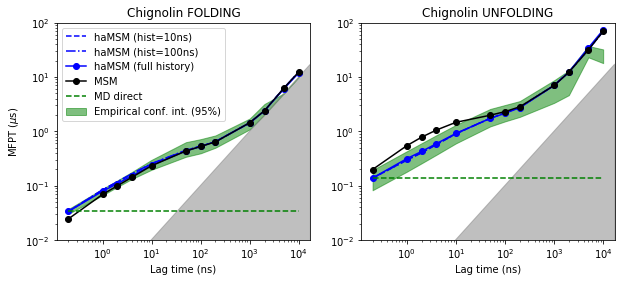

In [267]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)

plt.savefig('chignolin_mfpts_agglomerative.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative.pdf')
plt.show()

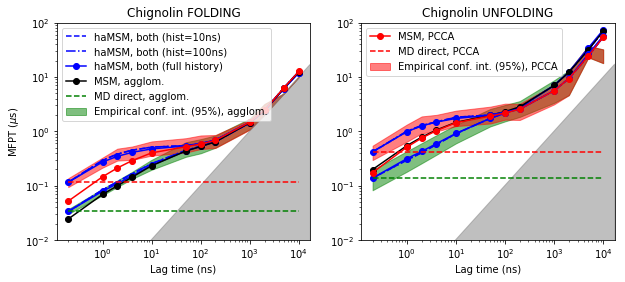

In [303]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')

plt.savefig('chignolin_mfpts_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_joint.pdf')
plt.show()

In [304]:
# also add PCCA states at such cutoff that we have 26 states in the intermediate too

In [37]:
chignolin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/chignolin_lag150ns_metastable_memberships.npy')

villin_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_lag100ns_metastable_memberships_3states.npy')
villin_misfold = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/villin_misfold.npy')

trpcage_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/trpcage_lag100ns_metastable_memberships.npy')

ntl9_membs = np.load('../vamp_scoring/automatic_eigenvalue/PAPER/pcca_data/ntl9_lag200ns_metastable_memberships.npy')

In [38]:
# returns [[folded], [unfolded], [intermediate]]
def get_sets(cutoff):
    chignolin_sets = [np.concatenate(np.argwhere(chignolin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(chignolin_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in chignolin_sets[0] and i not in chignolin_sets[1]:
            chignolin_sets[2].append(i)
    
    villin_sets = [np.concatenate(np.argwhere(villin_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(villin_membs[:,2] >= cutoff)), []]
    
    for i in range(100):
        if i not in villin_sets[0] and i not in villin_sets[1] and i not in villin_misfold:
            villin_sets[2].append(i)

    trpcage_sets = [np.concatenate(np.argwhere(trpcage_membs[:,0] >= cutoff)),
    np.concatenate(np.argwhere(trpcage_membs[:,1] >= cutoff)), []]
    
    for i in range(100):
        if i not in trpcage_sets[0] and i not in trpcage_sets[1]:
            trpcage_sets[2].append(i)

    ntl9_sets = [np.concatenate(np.argwhere(ntl9_membs[:,1] >= cutoff)),
    np.concatenate(np.argwhere(ntl9_membs[:,0] >= cutoff)), []]
    
    for i in range(100):
        if i not in ntl9_sets[0] and i not in ntl9_sets[1]:
            ntl9_sets[2].append(i)
    
    return (chignolin_sets, villin_sets, trpcage_sets, ntl9_sets)

In [39]:
len(get_sets(0.907)[0][2])

26

In [40]:
stateA = get_sets(0.907)[0][1] # unfolded
stateB = get_sets(0.907)[0][0] # folded

In [41]:
len(stateA), len(stateB)

(52, 22)

In [43]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 191/191


IndexError: index 156 is out of bounds for axis 1 with size 156

In [52]:
dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []


# skip models[1] which causes error above
for i,models_ in enumerate(models):
    
    if i == 1:
        empirical_mfptsAB.append(np.nan)
        empirical_mfptsBA.append(np.nan)

        std_errAB.append(np.nan)
        std_errBA.append(np.nan)

        nm_mfptsAB.append(np.nan)
        nm_mfptsBA.append(np.nan)

        nm_hist10ns_mfptsAB.append(np.nan)
        nm_hist10ns_mfptsBA.append(np.nan)

        nm_hist100ns_mfptsAB.append(np.nan)
        nm_hist100ns_mfptsBA.append(np.nan)
        
        continue
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 191/191
Number of A->B/B->A  events: 59/59
Number of A->B/B->A  events: 55/55
Number of A->B/B->A  events: 45/44
Number of A->B/B->A  events: 37/36
Number of A->B/B->A  events: 33/32
Number of A->B/B->A  events: 32/31
Number of A->B/B->A  events: 13/13
Number of A->B/B->A  events: 7/7
Number of A->B/B->A  events: 2/2
Number of A->B/B->A  events: 2/2


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


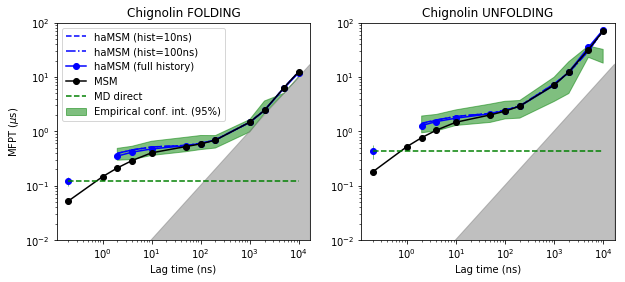

In [53]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_pcca_agglomsize_interm.png', dpi=300)
plt.savefig('chignolin_mfpts_pcca_agglomsize_interm.pdf')
plt.show()

In [90]:
# also see agglomerative clustering, picking t_cut at the start and end of the plateau

In [91]:
# calculated the agglomerative clustering above, just getting the macrostates here

In [93]:
# (np.array(t_AB_list)*0.2)[15:49]

In [108]:
pick = 15

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [109]:
len(stateA), len(stateB), 100 - (len(stateA)+len(stateB))

(25, 24, 51)

In [110]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 229/230
Number of A->B/B->A  events: 114/114
Number of A->B/B->A  events: 87/87
Number of A->B/B->A  events: 68/68
Number of A->B/B->A  events: 52/52
Number of A->B/B->A  events: 38/37
Number of A->B/B->A  events: 33/32
Number of A->B/B->A  events: 29/28
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  events: 7/7
Number of A->B/B->A  events: 2/2
Number of A->B/B->A  events: 2/2


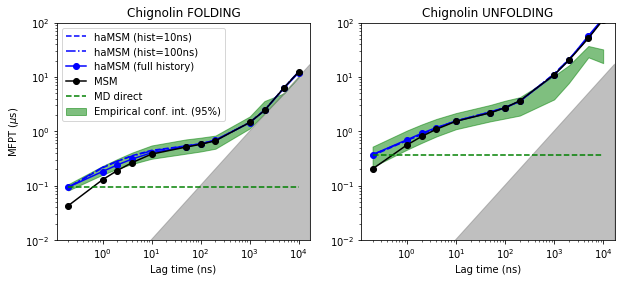

In [96]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_startplateau.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_startplateau.pdf')
plt.show()

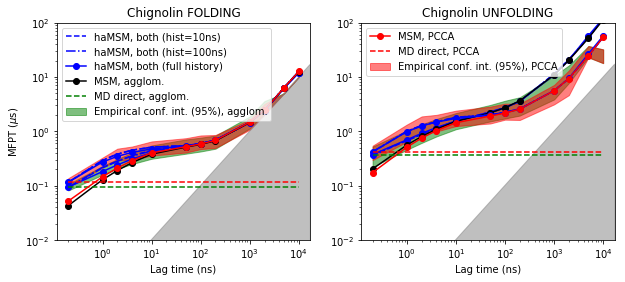

In [111]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')
ax1.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_startplateau_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_startplateau_joint.pdf')
plt.show()

In [101]:
pick = 48

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [105]:
len(stateA), len(stateB), 100 - (len(stateA)+len(stateB))

(67, 30, 3)

In [102]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 1328/1328
Number of A->B/B->A  events: 411/411
Number of A->B/B->A  events: 285/285
Number of A->B/B->A  events: 195/195
Number of A->B/B->A  events: 121/121
Number of A->B/B->A  events: 52/51
Number of A->B/B->A  events: 39/38
Number of A->B/B->A  events: 37/36
Number of A->B/B->A  events: 17/16
Number of A->B/B->A  events: 10/9
Number of A->B/B->A  events: 3/2
Number of A->B/B->A  events: 3/2


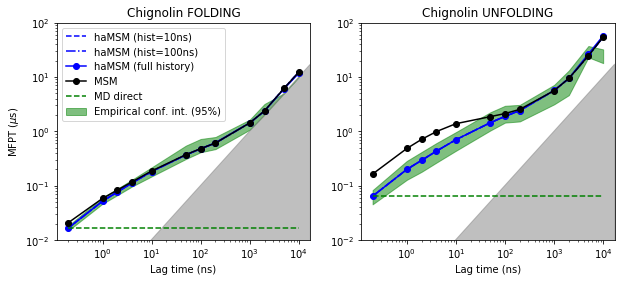

In [103]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_endplateau.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_endplateau.pdf')
plt.show()

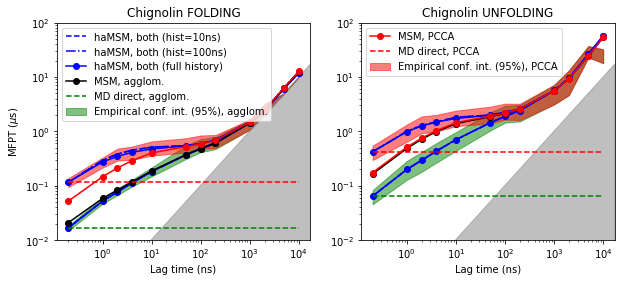

In [106]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_stopplateau_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_stopplateau_joint.pdf')
plt.show()

In [112]:
# now for both PCCA and agglomerative - calc. only MSM mfpt at different cutoffs / t_cut - do this later, now:

In [115]:
# do the above again, but for pcca set the number of microstates the same as from agglomerative

In [75]:
len(get_sets(0.9375)[0][2])

51

In [76]:
stateA = get_sets(0.9375)[0][1] # unfolded
stateB = get_sets(0.9375)[0][0] # folded

In [77]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB2 = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA2 = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

dt=0.0002

empirical_mfptsAB2 =[]
empirical_mfptsBA2 =[]
nm_mfptsAB2 = []
nm_mfptsBA2 = []

nm_hist10ns_mfptsAB2 = []
nm_hist10ns_mfptsBA2 = []

nm_hist20ns_mfptsAB2 = []
nm_hist20ns_mfptsBA2 = []

nm_hist50ns_mfptsAB2 = []
nm_hist50ns_mfptsBA2 = []

nm_hist100ns_mfptsAB2 = []
nm_hist100ns_mfptsBA2 = []

std_errAB2 = []
std_errBA2 = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB2.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA2.append(e_kinetics['mfptBA']*dt)
    
    std_errAB2.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA2.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB2.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA2.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB2.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA2.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB2.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA2.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 175/175


IndexError: index 165 is out of bounds for axis 1 with size 165

In [78]:
dt=0.0002

empirical_mfptsAB2 =[]
empirical_mfptsBA2 =[]

nm_mfptsAB2 = []
nm_mfptsBA2 = []

nm_hist10ns_mfptsAB2 = []
nm_hist10ns_mfptsBA2 = []

nm_hist100ns_mfptsAB2 = []
nm_hist100ns_mfptsBA2 = []

std_errAB2 = []
std_errBA2 = []
    
for i,models_ in enumerate(models):
    
    if i == 10 or i == 11:
        empirical_mfptsAB2.append(np.nan)
        empirical_mfptsBA2.append(np.nan)

        std_errAB2.append(np.nan)
        std_errBA2.append(np.nan)

        nm_mfptsAB2.append(np.nan)
        nm_mfptsBA2.append(np.nan)

        nm_hist10ns_mfptsAB2.append(np.nan)
        nm_hist10ns_mfptsBA2.append(np.nan)

        nm_hist100ns_mfptsAB2.append(np.nan)
        nm_hist100ns_mfptsBA2.append(np.nan)
        
        continue
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    skip10 = False
    skip100 = False
    
    try:    
        nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    except:
        nm_hist10ns_mfptsAB2.append(np.nan)
        nm_hist10ns_mfptsBA2.append(np.nan)
        skip10 = True
        
        pass
    
    try:    
        nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    except:
        nm_hist100ns_mfptsAB2.append(np.nan)
        nm_hist100ns_mfptsBA2.append(np.nan)
        skip100 = True
        
        pass
    
    nm_kinetics = nm_model.mfpts()
    e_kinetics = nm_model.empirical_mfpts()
    
    empirical_mfptsAB2.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA2.append(e_kinetics['mfptBA']*dt)
    
    std_errAB2.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA2.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB2.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA2.append(nm_kinetics['mfptBA']*dt)
    
    if not skip10:
        nm_hist10ns_mfptsAB2.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
        nm_hist10ns_mfptsBA2.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    if not skip100:
        nm_hist100ns_mfptsAB2.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
        nm_hist100ns_mfptsBA2.append(nm_model_hist100ns_kinetics['mfptBA']*dt)    

Number of A->B/B->A  events: 175/175
Number of A->B/B->A  events: 82/82
Number of A->B/B->A  events: 57/56
Number of A->B/B->A  events: 53/52
Number of A->B/B->A  events: 42/41
Number of A->B/B->A  events: 32/31
Number of A->B/B->A  events: 27/26
Number of A->B/B->A  events: 25/25
Number of A->B/B->A  events: 6/6
Number of A->B/B->A  events: 1/1


In [79]:
pick = 15

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

In [80]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 229/230
Number of A->B/B->A  events: 114/114
Number of A->B/B->A  events: 87/87
Number of A->B/B->A  events: 68/68
Number of A->B/B->A  events: 52/52
Number of A->B/B->A  events: 38/37
Number of A->B/B->A  events: 33/32
Number of A->B/B->A  events: 29/28
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  events: 7/7
Number of A->B/B->A  events: 2/2
Number of A->B/B->A  events: 2/2


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


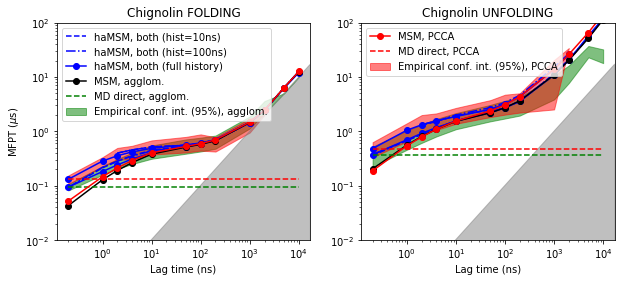

In [81]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_startplateau_same_nomicrostatesPCCA_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_startplateau_samenomicrostatesPCCA_joint.pdf')
plt.show()

In [82]:
print(len(get_sets(0.907)[0][2]))

stateA = get_sets(0.907)[0][1] # unfolded
stateB = get_sets(0.907)[0][0] # folded

26


In [83]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB2 = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA2 = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

dt=0.0002

empirical_mfptsAB2 =[]
empirical_mfptsBA2 =[]
nm_mfptsAB2 = []
nm_mfptsBA2 = []

nm_hist10ns_mfptsAB2 = []
nm_hist10ns_mfptsBA2 = []

nm_hist20ns_mfptsAB2 = []
nm_hist20ns_mfptsBA2 = []

nm_hist50ns_mfptsAB2 = []
nm_hist50ns_mfptsBA2 = []

nm_hist100ns_mfptsAB2 = []
nm_hist100ns_mfptsBA2 = []

std_errAB2 = []
std_errBA2 = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB2.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA2.append(e_kinetics['mfptBA']*dt)
    
    std_errAB2.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA2.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB2.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA2.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB2.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA2.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB2.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA2.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 191/191


IndexError: index 156 is out of bounds for axis 1 with size 156

In [84]:
dt=0.0002

empirical_mfptsAB2 =[]
empirical_mfptsBA2 =[]

nm_mfptsAB2 = []
nm_mfptsBA2 = []

nm_hist10ns_mfptsAB2 = []
nm_hist10ns_mfptsBA2 = []

nm_hist100ns_mfptsAB2 = []
nm_hist100ns_mfptsBA2 = []

std_errAB2 = []
std_errBA2 = []
    
for i,models_ in enumerate(models):
    
    if i == 10 or i == 11:
        empirical_mfptsAB2.append(np.nan)
        empirical_mfptsBA2.append(np.nan)

        std_errAB2.append(np.nan)
        std_errBA2.append(np.nan)

        nm_mfptsAB2.append(np.nan)
        nm_mfptsBA2.append(np.nan)

        nm_hist10ns_mfptsAB2.append(np.nan)
        nm_hist10ns_mfptsBA2.append(np.nan)

        nm_hist100ns_mfptsAB2.append(np.nan)
        nm_hist100ns_mfptsBA2.append(np.nan)
        
        continue
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    skip10 = False
    skip100 = False
    
    try:    
        nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    except:
        nm_hist10ns_mfptsAB2.append(np.nan)
        nm_hist10ns_mfptsBA2.append(np.nan)
        skip10 = True
        
        pass
    
    try:    
        nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    except:
        nm_hist100ns_mfptsAB2.append(np.nan)
        nm_hist100ns_mfptsBA2.append(np.nan)
        skip100 = True
        
        pass
    
    nm_kinetics = nm_model.mfpts()
    e_kinetics = nm_model.empirical_mfpts()
    
    empirical_mfptsAB2.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA2.append(e_kinetics['mfptBA']*dt)
    
    std_errAB2.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA2.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB2.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA2.append(nm_kinetics['mfptBA']*dt)
    
    if not skip10:
        nm_hist10ns_mfptsAB2.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
        nm_hist10ns_mfptsBA2.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    if not skip100:
        nm_hist100ns_mfptsAB2.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
        nm_hist100ns_mfptsBA2.append(nm_model_hist100ns_kinetics['mfptBA']*dt)    

Number of A->B/B->A  events: 191/191
Number of A->B/B->A  events: 84/84
Number of A->B/B->A  events: 59/59
Number of A->B/B->A  events: 55/55
Number of A->B/B->A  events: 45/44
Number of A->B/B->A  events: 37/36
Number of A->B/B->A  events: 33/32
Number of A->B/B->A  events: 32/31
Number of A->B/B->A  events: 13/13
Number of A->B/B->A  events: 7/7


In [85]:
pick = 31

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 624/624
Number of A->B/B->A  events: 280/280
Number of A->B/B->A  events: 198/198
Number of A->B/B->A  events: 140/140
Number of A->B/B->A  events: 89/89
Number of A->B/B->A  events: 45/44
Number of A->B/B->A  events: 38/37
Number of A->B/B->A  events: 32/31
Number of A->B/B->A  events: 15/14
Number of A->B/B->A  events: 10/9
Number of A->B/B->A  events: 3/2
Number of A->B/B->A  events: 3/2


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


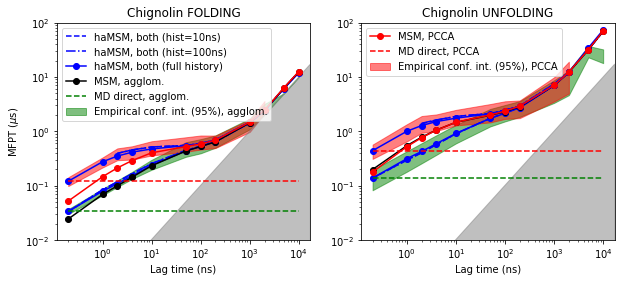

In [86]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_middleplateau_samenomicrostatesPCCA_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_middleplateau_samenomicrostatesPCCA_joint.pdf')
plt.show()

In [87]:
print(len(get_sets(0.7)[0][2]))

stateA = get_sets(0.7)[0][1] # unfolded
stateB = get_sets(0.7)[0][0] # folded

3


In [88]:
lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB2 = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA2 = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

dt=0.0002

empirical_mfptsAB2 =[]
empirical_mfptsBA2 =[]
nm_mfptsAB2 = []
nm_mfptsBA2 = []

nm_hist10ns_mfptsAB2 = []
nm_hist10ns_mfptsBA2 = []

nm_hist20ns_mfptsAB2 = []
nm_hist20ns_mfptsBA2 = []

nm_hist50ns_mfptsAB2 = []
nm_hist50ns_mfptsBA2 = []

nm_hist100ns_mfptsAB2 = []
nm_hist100ns_mfptsBA2 = []

std_errAB2 = []
std_errBA2 = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB2.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA2.append(e_kinetics['mfptBA']*dt)
    
    std_errAB2.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA2.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB2.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA2.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB2.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA2.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB2.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA2.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Process ForkPoolWorker-140:
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
Process ForkPoolWorker-139:
Process ForkPoolWorker-141:
Process ForkPoolWorker-137:
Process ForkPoolWorker-144:
Process ForkPoolWorker-142:
Process ForkPoolWorker-138:
Process ForkPoolWorker-143:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
  

In [164]:
pick = 48

#Selection of the t_cut
macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
# Folded and unfolded definition
stateA = big_clusters_list[pick][macrostates[0]]
stateB = big_clusters_list[pick][macrostates[1]]

lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

dt = 0.0002 # in micro-sec

lag_to_use = lags

lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

def calc_models(lag):
    
    nm_model = NonMarkovModel(dtrajs, stateA, stateB, lag_time=lag, sliding_window=True)
    
    # markov + color
    nm_model_hist10ns  = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=50)
    nm_model_hist100ns = MarkovPlusColorModel(dtrajs, stateA, stateB, lag_time=lag, hist_length=500)
    
    return [nm_model, nm_model_hist10ns, nm_model_hist100ns]

dt=0.0002

empirical_mfptsAB =[]
empirical_mfptsBA =[]
nm_mfptsAB = []
nm_mfptsBA = []

nm_hist10ns_mfptsAB = []
nm_hist10ns_mfptsBA = []

nm_hist20ns_mfptsAB = []
nm_hist20ns_mfptsBA = []

nm_hist50ns_mfptsAB = []
nm_hist50ns_mfptsBA = []

nm_hist100ns_mfptsAB = []
nm_hist100ns_mfptsBA = []

std_errAB = []
std_errBA = []

pool = multiprocessing.Pool(8)
    
models = pool.map(calc_models, lag_to_use)

pool.close()
pool.join()
    
for models_ in models:
    
    nm_model = models_[0]
    nm_model_hist10ns = models_[1]
    nm_model_hist100ns = models_[2]
    
    nm_kinetics = nm_model.mfpts()
    nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
    nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
    
    e_kinetics = nm_model.empirical_mfpts()
    
    
    empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
    empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)
    
    std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
    std_errBA.append(e_kinetics['std_err_mfptBA']*dt)
    
    nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
    nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)
    
    nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
    nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)
    
    nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
    nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)

Number of A->B/B->A  events: 1328/1328
Number of A->B/B->A  events: 411/411
Number of A->B/B->A  events: 285/285
Number of A->B/B->A  events: 195/195
Number of A->B/B->A  events: 121/121
Number of A->B/B->A  events: 52/51
Number of A->B/B->A  events: 39/38
Number of A->B/B->A  events: 37/36
Number of A->B/B->A  events: 17/16
Number of A->B/B->A  events: 10/9
Number of A->B/B->A  events: 3/2
Number of A->B/B->A  events: 3/2


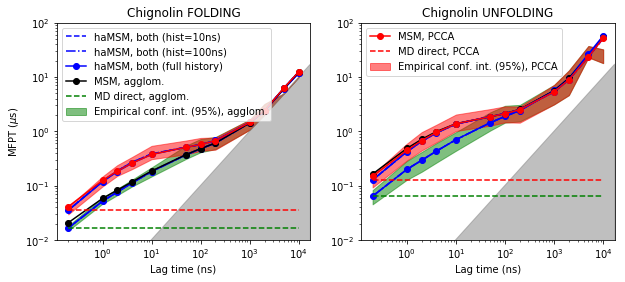

In [166]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

empirical_mfptAB_max2 = np.array(empirical_mfptsAB2) + 2*np.array(std_errAB2)
empirical_mfptAB_min2 = np.array(empirical_mfptsAB2) - 2*np.array(std_errAB2)

empirical_mfptBA_max2 = np.array(empirical_mfptsBA2) + 2*np.array(std_errBA2)
empirical_mfptBA_min2 = np.array(empirical_mfptsBA2) - 2*np.array(std_errBA2)

fig=plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(121)
ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                 alpha=0.5, color="green", label="Empirical conf. int. (95%), agglom." )

ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min2, empirical_mfptAB_max2,
                 alpha=0.5, color="red")


ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM, both (hist=10ns)", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM, both (hist=100ns)", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM, both (full history)", c='b')

ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB2, "--", c='b')
ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB2, "-.", c='b')
ax1.plot(lag_to_use_ns, nm_mfptsAB2, "-o", c='b')

ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM, agglom.")
ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct, agglom.')

ax1.plot(lag_to_use_ns, msm_mfptAB2, "-o",color='r')
ax1.plot(lag_to_use_ns, [empirical_mfptsAB2[0] for i in lag_to_use_ns], "--", color='red')
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(0.1e-1, 1e2)
plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)


ax2 = fig.add_subplot(122, sharey=ax1)
ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                 alpha=0.5, color="green")

ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min2, empirical_mfptBA_max2,
                 alpha=0.5, color="red", label="Empirical conf. int. (95%), PCCA" )

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k')

ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA2, "--", c='b')
ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA2, "-.", c='b')
ax2.plot(lag_to_use_ns, nm_mfptsBA2, "-o", c='b' )

ax2.plot(lag_to_use_ns, msm_mfptBA2, "-o",color='r', label="MSM, PCCA")

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green')

ax2.plot(lag_to_use_ns, [empirical_mfptsBA2[0] for i in lag_to_use_ns], "--", color='red', label='MD direct, PCCA')
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
plt.legend(loc='upper left')
ax2.set_ylim(0.1e-1, 1e2)

plt.savefig('chignolin_mfpts_agglomerative_stopplateau_samenomicrostatesPCCA_joint.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_stopplateau_samenomicrostatesPCCA_joint.pdf')
plt.show()

In [167]:
# back to just comparing MSMs at large selection of cutoffs

In [66]:
msm_mfptAB_s = []
msnom_mfptBA_s = []
intermediate_lens = []

for cutoff in (list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001))):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0] # folded
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

    msm_mfptAB_s.append(msm_mfptAB)
    msm_mfptBA_s.append(msm_mfptBA)

intermediate_lens = np.array(intermediate_lens)

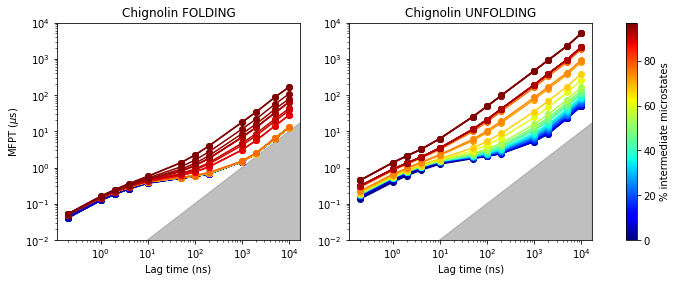

In [68]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

fig=plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)

#colors = plt.cm.jet(np.linspace(0,1,len(msm_mfptAB_s)))

norm = matplotlib.colors.Normalize(vmin=intermediate_lens.min(), vmax=intermediate_lens.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i,msm_mfptAB in enumerate(msm_mfptAB_s):
    ax1.plot(lag_to_use_ns, msm_mfptAB, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-2, 1e4)
#plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

for i,msm_mfptBA in enumerate(msm_mfptBA_s):
    ax2.plot(lag_to_use_ns, msm_mfptBA, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-2, 1e4)

cbar = fig.colorbar(cmap, ax=[ax1,ax2])
cbar.set_label('% intermediate microstates')

plt.savefig('chignolin_mfpts_pcca_msms.png', dpi=300)
plt.savefig('chignolin_mfpts_pcca_msms.pdf')
plt.show()

In [74]:
msm_mfptAB_s = []
msm_mfptBA_s = []
intermediate_lens = []

for cutoff in (list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.945, 0.005))):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0] # folded
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

    msm_mfptAB_s.append(msm_mfptAB)
    msm_mfptBA_s.append(msm_mfptBA)
    
intermediate_lens = np.array(intermediate_lens)    

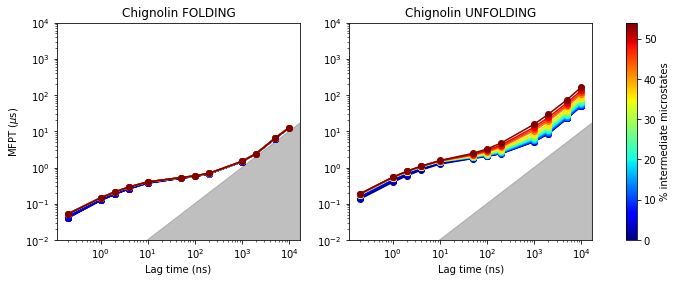

In [70]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

fig=plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)

#colors = plt.cm.jet(np.linspace(0,1,len(msm_mfptAB_s)))

norm = matplotlib.colors.Normalize(vmin=intermediate_lens.min(), vmax=intermediate_lens.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i,msm_mfptAB in enumerate(msm_mfptAB_s):
    ax1.plot(lag_to_use_ns, msm_mfptAB, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-2, 1e4)
#plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

for i,msm_mfptBA in enumerate(msm_mfptBA_s):
    ax2.plot(lag_to_use_ns, msm_mfptBA, "-o", color=cmap.to_rgba(intermediate_lens[i]))

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-2, 1e4)

cbar = fig.colorbar(cmap, ax=[ax1,ax2])
cbar.set_label('% intermediate microstates')

plt.savefig('chignolin_mfpts_pcca_agglomrange_msms.png', dpi=300)
plt.savefig('chignolin_mfpts_pcca_agglomrange_msms.pdf')
plt.show()

In [77]:
msm_mfptAB_s = []
msm_mfptBA_s = []
intermediate_lens2 = []

for pick in range(15,49):

    #Selection of the t_cut
    macrostates = biggest_clusters_indexes(big_clusters_list[pick], n_pick=2)
    # Folded and unfolded definition
    stateA = big_clusters_list[pick][macrostates[0]]
    stateB = big_clusters_list[pick][macrostates[1]]
    
    intermediate_lens2.append(100 - (len(stateA)+len(stateB)))

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])
    
    msm_mfptAB_s.append(msm_mfptAB)
    msm_mfptBA_s.append(msm_mfptBA)       

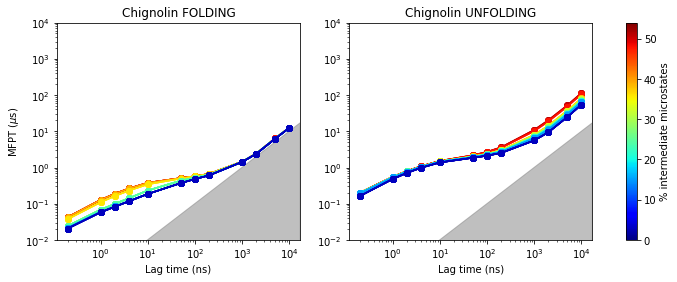

In [79]:
lag_to_use_ns = np.array(lag_to_use) * 0.2
lag_to_use_us = np.array(lag_to_use) * 0.0002

fig=plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)

#colors = plt.cm.jet(np.linspace(0,1,len(msm_mfptAB_s)))

norm = matplotlib.colors.Normalize(vmin=intermediate_lens.min(), vmax=intermediate_lens.max())
cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.jet)
cmap.set_array([])

for i,msm_mfptAB in enumerate(msm_mfptAB_s):
    ax1.plot(lag_to_use_ns, msm_mfptAB, "-o", color=cmap.to_rgba(intermediate_lens2[i]))

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_title("Chignolin FOLDING")
ax1.set_xlabel("Lag time (ns)")
ax1.set_ylabel("MFPT ($\mu$s)")
ax1.set_ylim(1e-2, 1e4)
#plt.legend(loc='upper left')
xlim = ax1.get_xlim()
ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax1.set_xlim(xlim)

ax2 = fig.add_subplot(122, sharey=ax1)

for i,msm_mfptBA in enumerate(msm_mfptBA_s):
    ax2.plot(lag_to_use_ns, msm_mfptBA, "-o", color=cmap.to_rgba(intermediate_lens2[i]))

ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_title("Chignolin UNFOLDING")
ax2.set_xlabel("Lag time (ns)")
xlim = ax2.get_xlim()
ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
ax2.set_xlim(xlim)
ax2.set_ylim(1e-2, 1e4)

cbar = fig.colorbar(cmap, ax=[ax1,ax2])
cbar.set_label('% intermediate microstates')

plt.savefig('chignolin_mfpts_agglomerative_msms.png', dpi=300)
plt.savefig('chignolin_mfpts_agglomerative_msms.pdf')
plt.show()

In [58]:
# do full MFPT plots for higher numbers of intermediate states in PCCA

In [59]:
intermediate_lens = []

for cutoff in (list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001))):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0] # folded
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

In [60]:
intermediate_lens[25:][::3]

[54, 72, 88, 91, 93, 97]

In [61]:
msm_mfptAB_s = []
msnom_mfptBA_s = []
intermediate_lens = []

for cutoff in (list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001)))[25:][::3]:

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0] # folded
    
    intermediate_lens.append(100 - (len(stateA)+len(stateB)))

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000, 10000, 25000, 50000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]

    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

    msm_mfptAB_s.append(msm_mfptAB)
    msm_mfptBA_s.append(msm_mfptBA)

intermediate_lens = np.array(intermediate_lens)

In [62]:
intermediate_lens

array([54, 72, 88, 91, 93, 97])

In [90]:
for i,cutoff in enumerate((list(np.arange(0.5, 0.85, 0.05)) + list(np.arange(0.85, 0.95, 0.005)) + list(np.arange(0.95, 0.99, 0.01)) + list(np.arange(0.99, 0.999, 0.001)))[25:][::3]):

    stateA = get_sets(cutoff)[0][1] # unfolded
    stateB = get_sets(cutoff)[0][0] # folded

    lags = np.asarray([1, 5, 10, 20, 50, 250, 500, 1000, 5000])

    msm = [pyemma.msm.estimate_markov_model(list(dtrajs), lag=lag, dt_traj='0.0002 us') for lag in lags]

    dt = 0.0002 # in micro-sec

    lag_to_use = lags

    lag_index = [ get_lagtime_from_array(lags, element*0.2)[0] for element in lag_to_use ]


    msm_mfptAB = np.asarray([msm[lag_index[i]].mfpt(stateA, stateB) for i in range(len(lag_to_use))])
    msm_mfptBA = np.asarray([msm[lag_index[i]].mfpt(stateB, stateA) for i in range(len(lag_to_use))])

    dt=0.0002

    empirical_mfptsAB =[]
    empirical_mfptsBA =[]
    nm_mfptsAB = []
    nm_mfptsBA = []

    nm_hist10ns_mfptsAB = []
    nm_hist10ns_mfptsBA = []

    nm_hist100ns_mfptsAB = []
    nm_hist100ns_mfptsBA = []

    std_errAB = []
    std_errBA = []

    pool = multiprocessing.Pool(8)

    models = pool.map(calc_models, lag_to_use)

    pool.close()
    pool.join()

    for models_ in models:

        nm_model = models_[0]
        nm_model_hist10ns = models_[1]
        nm_model_hist100ns = models_[2]

        skip10 = False
        skip100 = False
        
        try:
            e_kinetics = nm_model.empirical_mfpts()
            x = e_kinetics['mfptAB']*dt
        except:
            empirical_mfptsAB.append(np.nan)
            empirical_mfptsBA.append(np.nan)
            std_errAB.append(np.nan)
            std_errBA.append(np.nan)
            nm_mfptsAB.append(np.nan)
            nm_mfptsBA.append(np.nan)
            nm_hist10ns_mfptsAB.append(np.nan)
            nm_hist10ns_mfptsBA.append(np.nan)
            nm_hist100ns_mfptsAB.append(np.nan)
            nm_hist100ns_mfptsBA.append(np.nan)
            
            continue

        try:    
            nm_model_hist10ns_kinetics = nm_model_hist10ns.mfpts()
        except:
            nm_hist10ns_mfptsAB.append(np.nan)
            nm_hist10ns_mfptsBA.append(np.nan)
            skip10 = True

            pass

        try:    
            nm_model_hist100ns_kinetics = nm_model_hist100ns.mfpts()
        except:
            nm_hist100ns_mfptsAB.append(np.nan)
            nm_hist100ns_mfptsBA.append(np.nan)
            skip100 = True

            pass

        nm_kinetics = nm_model.mfpts()
        e_kinetics = nm_model.empirical_mfpts()


        empirical_mfptsAB.append(e_kinetics['mfptAB']*dt)
        empirical_mfptsBA.append(e_kinetics['mfptBA']*dt)

        std_errAB.append(e_kinetics['std_err_mfptAB']*dt)
        std_errBA.append(e_kinetics['std_err_mfptBA']*dt)

        nm_mfptsAB.append(nm_kinetics['mfptAB']*dt)
        nm_mfptsBA.append(nm_kinetics['mfptBA']*dt)

        if not skip10:
            nm_hist10ns_mfptsAB.append(nm_model_hist10ns_kinetics['mfptAB']*dt)
            nm_hist10ns_mfptsBA.append(nm_model_hist10ns_kinetics['mfptBA']*dt)

        if not skip100:
            nm_hist100ns_mfptsAB.append(nm_model_hist100ns_kinetics['mfptAB']*dt)
            nm_hist100ns_mfptsBA.append(nm_model_hist100ns_kinetics['mfptBA']*dt)
        
        
    lag_to_use_ns = np.array(lag_to_use) * 0.2
    lag_to_use_us = np.array(lag_to_use) * 0.0002

    empirical_mfptAB_max = np.array(empirical_mfptsAB) + 2*np.array(std_errAB)
    empirical_mfptAB_min = np.array(empirical_mfptsAB) - 2*np.array(std_errAB)

    empirical_mfptBA_max = np.array(empirical_mfptsBA) + 2*np.array(std_errBA)
    empirical_mfptBA_min = np.array(empirical_mfptsBA) - 2*np.array(std_errBA)

    fig=plt.figure(figsize = (10,4))

    ax1 = fig.add_subplot(121)
    ax1.fill_between(lag_to_use_ns, empirical_mfptAB_min, empirical_mfptAB_max,
                     alpha=0.5, color="green", label="Empirical conf. int. (95%)" )


    ax1.plot(lag_to_use_ns, nm_hist10ns_mfptsAB, "--", label="haMSM (hist=10ns)", c='b')
    ax1.plot(lag_to_use_ns, nm_hist100ns_mfptsAB, "-.", label="haMSM (hist=100ns)", c='b')
    ax1.plot(lag_to_use_ns, nm_mfptsAB, "-o", label="haMSM (full history)", c='b')

    ax1.plot(lag_to_use_ns, msm_mfptAB, "-o",color='k', label="MSM")
    ax1.plot(lag_to_use_ns, [empirical_mfptsAB[0] for i in lag_to_use_ns], "--", color='green',label='MD direct')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_title("Chignolin FOLDING")
    ax1.set_xlabel("Lag time (ns)")
    ax1.set_ylabel("MFPT ($\mu$s)")
    ax1.set_ylim(0.1e-1, 1e2)
    plt.legend(loc='upper left')
    xlim = ax1.get_xlim()
    ax1.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
    ax1.set_xlim(xlim)

    ax2 = fig.add_subplot(122, sharey=ax1)
    ax2.fill_between(lag_to_use_ns, empirical_mfptBA_min, empirical_mfptBA_max,
                     alpha=0.5, color="green", label="Empirical conf. int. (95%)" )

    ax2.plot(lag_to_use_ns, nm_hist10ns_mfptsBA, "--", label="haMSM (hist=10ns)", c='b')
    ax2.plot(lag_to_use_ns, nm_hist100ns_mfptsBA, "-.", label="haMSM (hist=100ns)", c='b')
    ax2.plot(lag_to_use_ns, nm_mfptsBA, "-o", label="haMSM (full history)", c='b' )

    ax2.plot(lag_to_use_ns, msm_mfptBA, "-o",color='k', label="MSM")

    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_title("Chignolin UNFOLDING")
    ax2.set_xlabel("Lag time (ns)")
    ax2.plot(lag_to_use_ns, [empirical_mfptsBA[0] for i in lag_to_use_ns], "--", color='green', label='MD direct')
    xlim = ax2.get_xlim()
    ax2.fill_between([0, xlim[1]], [0, xlim[1]/1000], alpha=0.5, color='grey')
    ax2.set_xlim(xlim)
    ax2.set_ylim(0.1e-1, 1e2)

    plt.savefig('chignolin_mfpts_pcca_largesize_%d.png' % i, dpi=300)
    plt.savefig('chignolin_mfpts_pcca_largesize_%d.pdf' % i)
    plt.close()

Number of A->B/B->A  events: 174/174
Number of A->B/B->A  events: 174/174
Number of A->B/B->A  events: 82/82
Number of A->B/B->A  events: 82/82
Number of A->B/B->A  events: 57/56
Number of A->B/B->A  events: 57/56
Number of A->B/B->A  events: 53/52
Number of A->B/B->A  events: 53/52
Number of A->B/B->A  events: 42/41
Number of A->B/B->A  events: 42/41
Number of A->B/B->A  events: 31/31
Number of A->B/B->A  events: 31/31
Number of A->B/B->A  events: 24/24
Number of A->B/B->A  events: 24/24
Number of A->B/B->A  events: 23/23
Number of A->B/B->A  events: 23/23
Number of A->B/B->A  events: 6/6
Number of A->B/B->A  events: 6/6


/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


Number of A->B/B->A  events: 136/135
Number of A->B/B->A  events: 136/135
Number of A->B/B->A  events: 71/71
Number of A->B/B->A  events: 71/71
Number of A->B/B->A  events: 47/46
Number of A->B/B->A  events: 47/46
Number of A->B/B->A  events: 43/42
Number of A->B/B->A  events: 43/42
Number of A->B/B->A  events: 29/29
Number of A->B/B->A  events: 29/29
Number of A->B/B->A  events: 17/17
Number of A->B/B->A  events: 17/17
Number of A->B/B->A  events: 11/11
Number of A->B/B->A  events: 11/11
Number of A->B/B->A  events: 4/4
Number of A->B/B->A  events: 4/4
Number of A->B/B->A  events: 0/0
Number of A->B/B->A  events: 52/52
Number of A->B/B->A  events: 52/52
Number of A->B/B->A  events: 39/39
Number of A->B/B->A  events: 39/39
Number of A->B/B->A  events: 32/32
Number of A->B/B->A  events: 32/32
Number of A->B/B->A  events: 28/28
Number of A->B/B->A  events: 28/28
Number of A->B/B->A  events: 20/20
Number of A->B/B->A  events: 20/20
Number of A->B/B->A  events: 12/12
Number of A->B/B->A  e